# Invoke SparkContext

## SparkSession

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Project") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

## Load Data

In [3]:
from pyspark import SQLContext

print("Links dataset")
links = spark.read.load("gs://bdpp-movie-recommender-system-bucket/notebooks/jupyter/Data/links.csv",format="csv", inferSchema="true", header="true")
links.show(10)

print("Movies dataset")
movies = spark.read.load("gs://bdpp-movie-recommender-system-bucket/notebooks/jupyter/Data/movies.csv",format="csv", inferSchema="true", header="true")
movies.show(10)

print("Rarings dataset")
old_ratings = spark.read.load("gs://bdpp-movie-recommender-system-bucket/notebooks/jupyter/Data/ratings.csv",format="csv", inferSchema="true", header="true")
old_ratings.show(10)

print("Tags dataset")
tags = spark.read.load("gs://bdpp-movie-recommender-system-bucket/notebooks/jupyter/Data/tags.csv",format="csv", inferSchema="true", header="true")
tags.show(10)

Links dataset
+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
|      4|114885| 31357|
|      5|113041| 11862|
|      6|113277|   949|
|      7|114319| 11860|
|      8|112302| 45325|
|      9|114576|  9091|
|     10|113189|   710|
+-------+------+------+
only showing top 10 rows

Movies dataset
+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|       

# Learn more about the data 

### The most intresting dataset are "ratings" and "movies" 

In [4]:
#Drop the column timestamp Ratings dataset. 
ratings = old_ratings.drop("timestamp")
ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



### Merging the two datasets together. Ratings dataset with Movies dataset

In [5]:
ratings_movies = ratings.join(movies, ["movieId"])
ratings_movies.show()

+-------+------+------+--------------------+--------------------+
|movieId|userId|rating|               title|              genres|
+-------+------+------+--------------------+--------------------+
|      1|     1|   4.0|    Toy Story (1995)|Adventure|Animati...|
|      3|     1|   4.0|Grumpier Old Men ...|      Comedy|Romance|
|      6|     1|   4.0|         Heat (1995)|Action|Crime|Thri...|
|     47|     1|   5.0|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     50|     1|   5.0|Usual Suspects, T...|Crime|Mystery|Thr...|
|     70|     1|   3.0|From Dusk Till Da...|Action|Comedy|Hor...|
|    101|     1|   5.0|Bottle Rocket (1996)|Adventure|Comedy|...|
|    110|     1|   4.0|   Braveheart (1995)|    Action|Drama|War|
|    151|     1|   5.0|      Rob Roy (1995)|Action|Drama|Roma...|
|    157|     1|   5.0|Canadian Bacon (1...|          Comedy|War|
|    163|     1|   5.0|    Desperado (1995)|Action|Romance|We...|
|    216|     1|   5.0|Billy Madison (1995)|              Comedy|
|    223| 

## Look for missing values

In [6]:
import pyspark.sql.functions as F
ratings_null = ratings.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in ratings.columns])
ratings_null.show()
movies_null = movies.agg(*[F.count(F.when(F.isnull(c), c)).alias(c) for c in movies.columns])
movies_null.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     0|      0|     0|
+------+-------+------+

+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
|      0|    0|     0|
+-------+-----+------+



In [7]:
print("The amount of movie id's:")
movies.select('movieId').distinct().count()
#data.select('movieId').distinct().count()

The amount of movie id's:


9742

In [8]:
print("The amount of ratings id's:")
ratings.select('rating').distinct().count()

The amount of ratings id's:


10

In [9]:
print("The amount of user id's:")
ratings.select('userId').distinct().count()
#data.select('userId').distinct().count()

The amount of user id's:


610

In [10]:
print("The amount of movie titles:")
movies.select('title').distinct().count()
#data.select('title').distinct().count()

The amount of movie titles:


9737

In [11]:
print("The amount of genres:")
movies.select('genres').distinct().count()
#data.select('genres').distinct().count()

The amount of genres:


951

## Describe the data

In [12]:
import pyspark.sql.functions as sqlFunc
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

df_stats = ratings.select(
    _mean(col('rating')).alias('mean'),
    _stddev(col('rating')).alias('std')
).collect()

mean = df_stats[0]['mean']
std = df_stats[0]['std']

ratings.describe().show()
movies.describe().show()
ratings_movies.describe().show()

+-------+------------------+----------------+------------------+
|summary|            userId|         movieId|            rating|
+-------+------------------+----------------+------------------+
|  count|            100836|          100836|            100836|
|   mean|326.12756356856676|19435.2957177992| 3.501556983616962|
| stddev| 182.6184914635004|35530.9871987003|1.0425292390606342|
|    min|                 1|               1|               0.5|
|    max|               610|          193609|               5.0|
+-------+------------------+----------------+------------------+

+-------+------------------+--------------------+------------------+
|summary|           movieId|               title|            genres|
+-------+------------------+--------------------+------------------+
|  count|              9742|                9742|              9742|
|   mean|42200.353623485935|                null|              null|
| stddev| 52160.49485443825|                null|              null|


## View average ratings for every movie

In [13]:
ratings_movies_mean_std = ratings_movies.groupBy("movieId", "title").agg(sqlFunc.mean("rating").alias("rating_mean"), sqlFunc.stddev("rating").alias("rating_std"))
ratings_movies_mean_std.show()

+-------+--------------------+------------------+-------------------+
|movieId|               title|       rating_mean|         rating_std|
+-------+--------------------+------------------+-------------------+
|   2657|Rocky Horror Pict...|3.3412698412698414| 1.1137896541776637|
|   2076|  Blue Velvet (1986)|3.9456521739130435|  0.889620773573182|
|    493|Menace II Society...|3.6666666666666665| 0.6154574548966637|
|    881|    First Kid (1996)|               2.1| 0.8944271909999159|
|    442|Demolition Man (1...|3.0925925925925926| 0.9940796972297768|
|   6548|  Bad Boys II (2003)|2.8823529411764706|   1.21872643265298|
| 141688|       Legend (2015)|               3.5| 0.7071067811865476|
|   2171|Next Stop Wonderl...|            3.3125| 0.9613049166924836|
|   4085|Beverly Hills Cop...| 3.402173913043478| 0.7573313176131573|
|  45447|Da Vinci Code, Th...| 3.122448979591837| 0.8510447760748865|
|  38886|Squid and the Wha...|3.4444444444444446| 0.8819171036881969|
| 142997|Hotel Trans

## Check the users that have rated the most and the least number of movies

In [14]:
from pyspark.sql.functions import *
ratings.groupBy("userId").agg(count("*").alias("number_cnt")).orderBy(desc("number_cnt")).show() 
ratings.groupBy("userId").agg(count("*").alias("number_cnt")).orderBy(asc("number_cnt")).show()

+------+----------+
|userId|number_cnt|
+------+----------+
|   414|      2698|
|   599|      2478|
|   474|      2108|
|   448|      1864|
|   274|      1346|
|   610|      1302|
|    68|      1260|
|   380|      1218|
|   606|      1115|
|   288|      1055|
|   249|      1046|
|   387|      1027|
|   182|       977|
|   307|       975|
|   603|       943|
|   298|       939|
|   177|       904|
|   318|       879|
|   232|       862|
|   480|       836|
+------+----------+
only showing top 20 rows

+------+----------+
|userId|number_cnt|
+------+----------+
|   320|        20|
|   595|        20|
|   278|        20|
|   569|        20|
|   576|        20|
|   406|        20|
|   431|        20|
|   257|        20|
|   189|        20|
|   207|        20|
|   442|        20|
|   194|        20|
|    53|        20|
|   147|        20|
|    49|        21|
|   549|        21|
|   439|        21|
|   547|        21|
|    87|        21|
|   598|        21|
+------+----------+
only showing t

## Approximately how long every user have spent watching movies

In [15]:
ratings.groupBy("userId").agg(count("*").alias("number_cnt"))\
    .withColumn("years_Watching", round(col("number_cnt")* 100/ 60 / 24 / 365,3))\
    .orderBy(desc("years_Watching")).show(10)

+------+----------+--------------+
|userId|number_cnt|years_Watching|
+------+----------+--------------+
|   414|      2698|         0.513|
|   599|      2478|         0.471|
|   474|      2108|         0.401|
|   448|      1864|         0.355|
|   274|      1346|         0.256|
|   610|      1302|         0.248|
|    68|      1260|          0.24|
|   380|      1218|         0.232|
|   606|      1115|         0.212|
|   288|      1055|         0.201|
+------+----------+--------------+
only showing top 10 rows



## Converting to Pandas

In [16]:
import pandas as pd

movies_pd = movies.toPandas()
print(movies_pd.head())

ratings_pd = ratings.toPandas()
print(ratings_pd.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating
0       1        1     4.0
1       1        3     4.0
2       1        6     4.0
3       1       47     5.0
4       1       50     5.0


## Check the rating file info

In [17]:
print(ratings_pd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
userId     100836 non-null int32
movieId    100836 non-null int32
rating     100836 non-null float64
dtypes: float64(1), int32(2)
memory usage: 1.5 MB
None


## Check the movie file info

In [18]:
print(movies_pd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int32
title      9742 non-null object
genres     9742 non-null object
dtypes: int32(1), object(2)
memory usage: 190.3+ KB
None


# Vizulasing data

## Get a summary statics of ratings

In [19]:
import pandas as pd
ratings_pd = ratings.toPandas()
ratings_pd['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

## Display distribution of rating

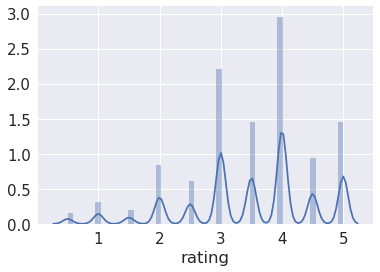

In [20]:
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

sns.distplot(ratings_pd['rating'].fillna(ratings_pd['rating'].median()))

## Join the 'movies_pd' and 'ratings_pd' files into one dataframe

In [21]:
# Join the 'movies_pd' and 'ratings_pd' files into one dataframe
dataset = pd.merge(pd.merge(movies_pd, ratings_pd), ratings_pd)
# Display 20 movies with highest ratings
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(10)

,title,genres,rating
56251,Eraserhead (1977),Drama|Horror,5.0
33888,Chasing Amy (1997),Comedy|Drama|Romance,5.0
20742,My Fair Lady (1964),Comedy|Drama|Musical|Romance,5.0
10168,Forrest Gump (1994),Comedy|Drama|Romance|War,5.0
10169,Forrest Gump (1994),Comedy|Drama|Romance|War,5.0
65379,Gosford Park (2001),Comedy|Drama|Mystery,5.0
10171,Forrest Gump (1994),Comedy|Drama|Romance|War,5.0
20739,My Fair Lady (1964),Comedy|Drama|Musical|Romance,5.0
10173,Forrest Gump (1994),Comedy|Drama|Romance|War,5.0
10174,Forrest Gump (1994),Comedy|Drama|Romance|War,5.0


## Average rating for every movie in descending order

In [22]:
dataset.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Karlson Returns (1970)                           5.0
Winter in Prostokvashino (1984)                  5.0
My Love (2006)                                   5.0
Sorority House Massacre II (1990)                5.0
Winnie the Pooh and the Day of Concern (1972)    5.0
Name: rating, dtype: float64

## Number of ratings for every movie in descending order

In [23]:
dataset.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

## The average of ratings of movies

In [24]:
ratings_= pd.DataFrame(dataset.groupby('title')['rating'].mean())
ratings_.head()

,rating
title,
"""11'09""""01 - September 11 (2002)""",4.0
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5
'Salem's Lot (2004),5.0


In [25]:
ratings_['num of ratings'] = pd.DataFrame(dataset.groupby('title')['rating'].count())
ratings_.head()

,rating,num of ratings
title,,
"""11'09""""01 - September 11 (2002)""",4.0,2
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1


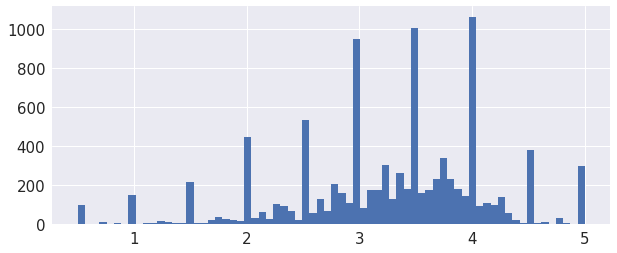

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
ratings_['rating'].hist(bins=70)

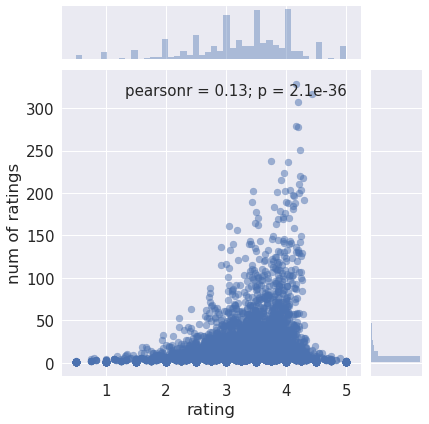

In [27]:
sns.jointplot(x='rating',y='num of ratings',data=ratings_,alpha=0.5)

## Vizulasing the number of ratings

### Top 10 most rated movies

In [28]:
ratings_.sort_values('num of ratings',ascending=False).head(10)

,rating,num of ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


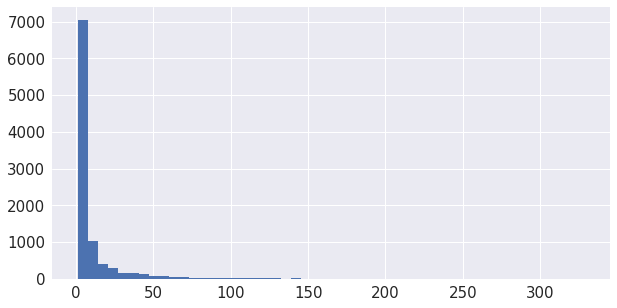

In [29]:
plt.figure(figsize=(10,5))
ratings_['num of ratings'].hist(bins=50)

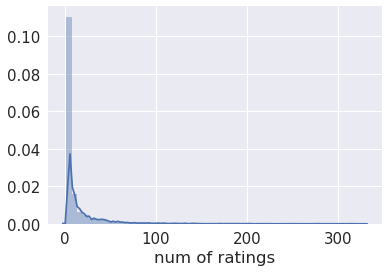

In [30]:
sns.distplot(ratings_['num of ratings'].fillna(ratings_['num of ratings'].median()))

# WorldCloud 

### Installed a pip package in the current Jupyter kernel

In [31]:
import sys
!{sys.executable} -m pip install 

You must give at least one requirement to install (see "pip help install")
You are using pip version 9.0.1, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Method that counts the number of times each of the genre keywords appears

In [32]:
import numpy as np
import wordcloud
from wordcloud import WordCloud, STOPWORDS

In [33]:
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    
    # converting the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

## WorldCloud of move genras

### Make a census of the genre keywords

In [34]:
genre_labels = set()
for s in movies_pd['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

### Calling the function, gives access to a list of genre keywords which are sorted by decreasing frequency

In [35]:
keyword_occurences, dum = count_word(movies_pd, 'genres', genre_labels)
keyword_occurences[:5]

[[u'Drama', 4361],
 [u'Comedy', 3756],
 [u'Thriller', 1894],
 [u'Action', 1828],
 [u'Romance', 1596]]

### Define the dictionary used to produce the genre wordcloud

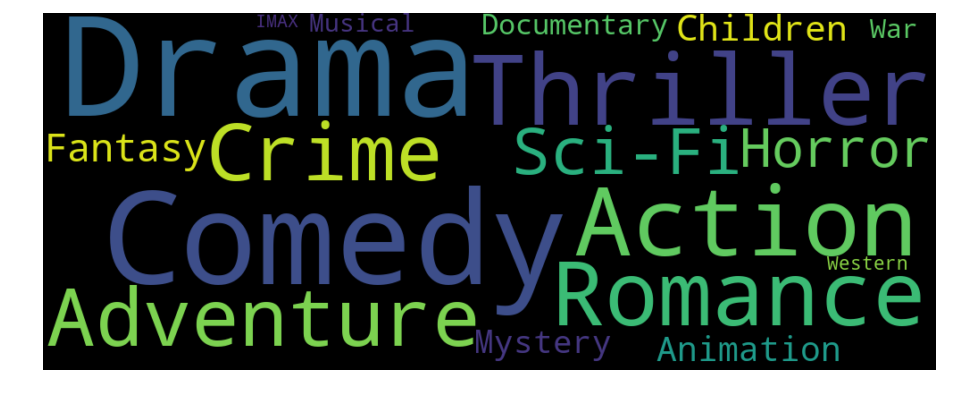

In [36]:
genres = dict()
trunc_occurences = keyword_occurences[0:18]
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='Black')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Alternating Least Squares Model

## Check the data types of each of the columns

In [37]:
print(ratings_movies.dtypes)
print(ratings.dtypes)
print(old_ratings.dtypes)

[('movieId', 'int'), ('userId', 'int'), ('rating', 'double'), ('title', 'string'), ('genres', 'string')]
[('userId', 'int'), ('movieId', 'int'), ('rating', 'double')]
[('userId', 'int'), ('movieId', 'int'), ('rating', 'double'), ('timestamp', 'int')]


### Training the ALS-model

In [100]:
from pyspark.ml.recommendation import ALS 

# Split into training and testing sets
#training, test = ratings_movies.randomSplit([0.8, 0.2])
training, test = ratings.randomSplit([0.8, 0.2])

# Build the recommendation model using ALS on the training data
# Cold start strategy is set to 'drop' to ensure that  don't get NaN evaluation metrics
als = ALS(userCol='userId', itemCol='movieId', ratingCol='rating', \
          implicitPrefs=True , coldStartStrategy="drop", nonnegative=True)

# Fit the ALS model to the training set
trained_model = als.fit(training)

## Testing the ALS-model

In [40]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = trained_model.transform(test)

# Evaluate the model by computing the RMSE on the test data
evaluator = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print('RMSE on test data: ' + str(rmse))

RMSE on test data: 3.22513020137


### Write RMSE result to GCP bucket¶

In [103]:
from google.cloud import storage

client = storage.Client()
bucket = client.bucket('bdpp-movie-recommender-system-bucket')

blob = bucket.get_blob('outputs/rmse_test.txt')

blob.upload_from_string('RMSE on test data: ' + str(rmse))

## Cross-validation to find the optimal model

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# create the parameter grid              
params = ParamGridBuilder().addGrid(als.maxIter, [5, 10, 15])\
                            .addGrid(als.regParam, [0.001, 0.01, 0.1])\
                            .addGrid(als.rank, [1, 5, 10,20]).build()
        
# instantiating crossvalidator estimator
cv = CrossValidator(estimator=als, estimatorParamMaps=params, evaluator=evaluator, numFolds=4)
cv_model = cv.fit(training)

#Extract best model from the tuning exercise using ParamGridBuilder
best_model = cv_model.bestModel

#Generate predictions and evaluate using RMSE
predictions = best_model.transform(test)
rmse_cross = evaluator.evaluate(predictions)


print('RMSE score from cross-validation: ' + str(rmse_cross))
print("**Best Model**")
print(" Rank:"), best_model.rank
print(" MaxIter:"), best_model._java_obj.parent().getMaxIter()
print( "RegParam:"), best_model._java_obj.parent().getRegParam()

RMSE score from cross-validation: 3.21682595888
**Best Model**
 Rank: 10
 MaxIter: 10
RegParam: 0.01


### Global variables - RMSE, Rank, MaxIter, RegParam

In [ ]:
RMSE_cross = str(rmse_cross)
bestRank = best_model.rank
bestMaxIter = best_model._java_obj.parent().getMaxIter()
bestRegRaram = best_model._java_obj.parent().getRegParam()

### Write the best hyperparameters and cross-validation score to GCP 

In [105]:
blob = bucket.get_blob('outputs/bestHyperParam_crossVal.txt')
blob.upload_from_string('RMSE from cross-validation data: ' + RMSE_cross + '\n' +
                       'Best rank value: ' + str(bestRank) + '\n' +
                       'Best number of max iterations: ' + str(bestMaxIter)	+ '\n' +
                       'Best regularization parameter: ' + str(bestRegRaram))
                        

### Show prediction 

In [ ]:
predictions.sort("userId", "rating").show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|     1|   2253|   2.0| 0.3464011|
|     1|   1408|   3.0| 0.4211987|
|     1|   3247|   3.0| 0.5052669|
|     1|   1377|   3.0|0.63743216|
|     1|   3243|   3.0|0.30339068|
|     1|   2657|   3.0| 0.5827893|
|     1|   2414|   3.0|0.40016624|
|     1|   1258|   3.0| 0.6357426|
|     1|   2012|   4.0| 0.6567277|
|     1|    480|   4.0| 0.8121699|
|     1|    590|   4.0| 0.5720466|
|     1|   3639|   4.0|0.41140547|
|     1|   1500|   4.0| 0.6696961|
|     1|   1552|   4.0|0.64052445|
|     1|   2366|   4.0|0.44552475|
|     1|   2099|   4.0|0.19005086|
|     1|   1060|   4.0|0.32025003|
|     1|   2054|   4.0|0.65673614|
|     1|    593|   4.0| 0.7195841|
|     1|   3440|   4.0|0.26894128|
+------+-------+------+----------+
only showing top 20 rows



## Incorporating the title, ids and genre of the movies

### Matching up the movie ids with the movie titles. 

In the cell below, a function 'name_retriever()' that takes in a 'movie_id' and returns a string that represents the movie title.

In [ ]:
def name_retriever(movie_id, movie_title_df):
    movie_title = movie_title_df.select(["movieId", "title"]).filter(movies["movieId"]==movie_id)
    return movie_title.collect()[0][1]

#### Test the metod

Should print "Winnie the Pooh and the Blustery Day (1968)".

In [ ]:
print(name_retriever(1023, movies))

Winnie the Pooh and the Blustery Day (1968)


### Matching up the title with the movie ids. 

In the cell below, a function 'id_retriever()' that takes in a 'movie_title' and returns a integer that represents the movie id.

In [ ]:
def id_retriever(movie_title, movie_title_df):
    movie_id = movie_title_df.select(["movieId", "title"]).filter(movies["title"]==movie_title)
    return movie_id.collect()[0][0]

#### Test the method 

Should print "1023". 

In [ ]:
print(id_retriever("Winnie the Pooh and the Blustery Day (1968)", movies))

1023


Matching up the movie_title or movie_id with the movie genre. In the cell below, created a function genre_retriever() that takes in a movie_title or movie_id and returns a string that represents the movie genre.

In [ ]:
def genre_retriever(movie_title_df, movie_title= None, movie_id= None):
    if movie_title is not None: 
        movie_genre = movie_title_df.select(["genres", "title"]).filter(movies["title"]==movie_title)
        return movie_genre.collect()[0][0]
    elif movie_id is not None:
        movie_genre = movie_title_df.select(["movieId", "genres"]).filter(movies["movieId"]==movie_id)
        return movie_genre.collect()[0][1]
    else:
        return None 

#### Test the method

Should print "Animation|Children|Musical".

In [ ]:
print(genre_retriever(movies, movie_title="Winnie the Pooh and the Blustery Day (1968)"))
print(genre_retriever(movies, movie_id=1023))

Animation|Children|Musical
Animation|Children|Musical


## Getting Predictions for a new user

This function is based on a users rating a movie. It returns $n$ number of highest recommended movies. This function will have multiple different steps to it:

- Adding the new ratings into the DataFrame 
- Fitting the ALS model
- Make recommendations for the user of choice
- Print out the names of the top $n$ recommendations in a reader-friendly manner

The function should take in the parameters:
- user_id : int
- new_ratings : list of tuples in the format (userId, title, rating)
- rating_df : spark DF containing ratings
- movie_df : spark DF containing movie titles
- rating_movie_df : joined spark DF of rating_df and movie_title_df
- num_recs : int

In [97]:
def new_user_recs(user_id, new_ratings, rating_df, movie_df, rating_movie_df, num_recs):
    # Creat a new row 
    new_row = spark.createDataFrame([(id_retriever(new_ratings[1], movie_df),\
                                      user_id, new_ratings[2], new_ratings[1], \
                                      genre_retriever(movie_df, movie_title= new_ratings[1]))])
    # combine the new ratings df with the rating_df
    temp_df = rating_movie_df
    temp_df = temp_df.union(new_row)
   
    # create an ALS model and fit it
    als = ALS(userCol='userId', itemCol='movieId', ratingCol='rating', \
          implicitPrefs=True , coldStartStrategy="drop", \
              regParam= bestRegRaram, maxIter= bestMaxIter, rank= bestRank)
        
    # fit the ALS model to the data-set
    fit_model = als.fit(temp_df)
    
    # make recommendations for all users using the recommendForAllUsers method
    all_user_recs = fit_model.recommendForAllUsers(num_recs)
    
    # get recommendations specifically for the new user that has been added to the DataFrame
    get_user = temp_df.select(als.getUserCol()).filter(col("userId") == user_id)
    get_rec_user = fit_model.recommendForUserSubset(get_user, num_recs)
       
    print("Based of your rating of " + new_ratings[1] + " you might also like to watch:")
    for num, recommendation in enumerate(get_rec_user.select("recommendations").collect()[0][0], 1):
        print(str(num)+ ". "+name_retriever(recommendation[0], movies))
    
    pass

#### Test the function

In [98]:
#new_ratings = (1, "Toy Story (1995)", 4)
new_user_recs(1, (1, "Toy Story (1995)", 4), ratings, movies, ratings_movies, 10)

Based of your rating of Toy Story (1995) you might also like to watch:
1. Star Wars: Episode V - The Empire Strikes Back (1980)
2. Star Wars: Episode IV - A New Hope (1977)
3. Star Wars: Episode VI - Return of the Jedi (1983)
4. Alien (1979)
5. Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
6. Jurassic Park (1993)
7. Back to the Future (1985)
8. Princess Bride, The (1987)
9. Men in Black (a.k.a. MIB) (1997)
10. Aliens (1986)
